## ETL data pipeline to process StreetEasy data
### Author: Shravan Kuchkula (email: shravan.kuchkula@gmail.com)
**Project Description**: 

An online real-estate company is interested in understanding `user enagagement` by analyzing user search patterns to send targeted emails to the users with valid searches. A valid search is termed as one where the search metadata contains `enabled:true` and number of clicks is atleast `3`.

 A daily snapshot of user search history and related data is saved to S3. Each file represents a single date, as noted by the filename: `inferred_users.20180330.csv.gz`. Each line in each file represents a *unique user*, as identified by `id` column. Information on each user's searches and engagement is stored in `searches` column. An example of this is shown below:

![rawdata](streeteasy-images/rawdata.png)
 

**Data Description**: The source data resides in S3 `s3://<s3-bucket>` for each day from **2018-01-20** till **2018-03-30**, as shown:
```bash
s3://<source-bucket>/
inferred_users.20180120.csv.gz
inferred_users.20180121.csv.gz
inferred_users.20180122.csv.gz
inferred_users.20180123.csv.gz
inferred_users.20180124.csv.gz
..
inferred_users.20180325.csv.gz
inferred_users.20180326.csv.gz
inferred_users.20180327.csv.gz
inferred_users.20180328.csv.gz
inferred_users.20180329.csv.gz
inferred_users.20180330.csv.gz
```

All this data needs to be processed using a data pipeline to answer the following **business questions:**
1. Produce a list of **unique "valid searches"**. 
2. Produce, for each date, the **total number of valid searches** that existed on that date.
3. Produce, for each date, the **total number of users** who had valid searches on that date.
4. Given this data, determine which is the **most engaging search.**
5. What would the email traffic look like if the definition of a valid search is changed from **3 clicks to 2 clicks**?
6. Report any interesting **trends over the timespan** of the data available.


**Data Pipeline design**:
The design of the pipeline can be summarized as:
- Extract data from source S3 location.
- Process and Transform it using python and custom **Airflow operators**.
- Load a clean dataset and intermediate artifacts to **destination S3 location**.
- Calculate summary statistics and load the summary stats into **Amazon Redshift**.

> Figure showns the structure of the data pipeline as represented by a Airflow DAG
![dag](streeteasy-images/dag.png)

Finally, I have made use of `Jupyter Notebook` to connect to the `Redshift` cluster and answer the questions of interest.

**Design Goals**:
As the data is stored in S3, we need a way to incrementally load each file, then process it and store that particular day's results back into S3. Doing so will allow us to perform further analysis later-on, on the cleaned dataset. Secondly, we need a way to aggregate the data and store it in a table to facilitate time-based analysis. Keeping these two goals in mind, the following tools were chosen:
- Apache Airflow will incrementally extract the data from S3 and process it *in-memory* and store the results back into a destination S3 bucket. The reason we need to process this in-memory is because, we don't want to download the file from S3 to airflow worker's disk, as this might fill-up the worker's disk and crash the worker process.
- Amazon Redshift is a simple cloud-managed data warehouse that can be integrated into pipelines without much effort. Airflow will then read the intermediate dataset created in the first step and aggregate the data per day and store it into a Redshift table.

**Pipeline Implementation**:
Apache Airflow is a Python framework for programmatically creating workflows in DAGs, e.g. ETL processes, generating reports, and retraining models on a daily basis. The Airflow UI automatically parses our DAG and creates a natural representation for the movement and transformation of data. A DAG simply is a collection of all the tasks you want to run, organized in a way that reflects their relationships and dependencies. A **DAG** describes *how* you want to carry out your workflow, and **Operators** determine *what* actually gets done.

By default, airflow comes with some simple built-in operators like `PythonOperator`, `BashOperator`, `DummyOperator` etc., however, airflow lets you extend the features of a `BaseOperator` and create custom operators. For this project, I developed two custom operators:

![operators](streeteasy-images/operators.png)

- **StreetEasyOperator**: Extract data from **source S3 bucket**, processes the data in-memory by applying a series of transformations found inside `transforms.py`, then loads it to destination S3 bucket. Please see the code here: 
- **ValidSearchStatsOperator**: Takes data from **destination S3 bucket**, aggregates the data on a per-day basis, and uploads it to Reshift table `search_stats`. Please see the code here:

Here's the directory organization:

```bash
├── README.md
├── docker-compose.yml
└── street-easy
    ├── dags
    │   ├── create_postgres_table.py
    │   └── street_easy.py
    ├── plugins
    │   ├── __init__.py
    │   ├── helpers
    │   │   ├── __init__.py
    │   │   └── transforms.py
    │   └── operators
    │       ├── __init__.py
    │       ├── extract_and_transform_streeteasy.py
    │       └── valid_search_stats.py
    └── requirements.txt
```


**Pipeline Schedule**: Our pipeline is required to adhere to the following guidelines:
* The DAG should run *daily* from `2018-01-20` to `2018-03-30`
* The DAG should not have any dependencies on past runs.
* On failure, the task is retried for 3 times.
* Retries happen every 5 minutes.
* Do not email on retry.

> Shown below is the data pipeline (street_easy DAG) execution starting on **2018-01-20** and ending on **2018-03-30**.
![airflow_tree_view](streeteasy-images/airflow_tree_view.png)
> Note: The data for *2018-01-29 and 2018-01-30* is not available, thus we are skipping over that.

**Destination S3 datasets and Redshift Table**:
After each successful run of the DAG, two files are stored in the destination bucket: 
* `s3://skuchkula-etl/unique_valid_searches_<date>.csv`: Contains a list of unique valid searches for each day.
* `s3://skuchkula-etl/valid_searches_<date>.csv`: Contains a dataset with the following fields:
    * user_id: Unique id of the user
    * num_valid_searches: Number of valid searches
    * avg_listings: Avg number of listings for that user
    * type_of_search: Did the user search for:
        * Only Rental
        * Only Sale
        * Both Rental and Sale
        * Neither
    * list_of_valid_searches: A list of valid searches for that user


**unique_valid_searches_{date}.csv** contains unique valid searches per day:
```bash
s3://skuchkula-etl/
unique_valid_searches_20180120.csv
unique_valid_searches_20180121.csv
unique_valid_searches_20180122.csv
unique_valid_searches_20180123.csv
unique_valid_searches_20180214.csv
...
```

**valid_searches_{date}.csv** contains the valid searches dataset per day:
```bash
s3://skuchkula-etl/
valid_searches_20180120.csv
valid_searches_20180121.csv
valid_searches_20180122.csv
valid_searches_20180123.csv
valid_searches_20180214.csv
...
```
**Amazon Redshift table:**

The `ValidSearchesStatsOperator` then takes each of datasets `valid_searches_{date}.csv` and calcuates summary stats and loads the results to **search_stats** table, as shown:

![redshift](streeteasy-images/redshift.png)


## Answering business questions using data

### Business question:  Produce a list of all unique "valid searches" given the above requirements.
The list of all unique searches is stored in the destination S3 bucket: `s3://skuchkula-etl/unique_valid_searches_{date}.csv`. An example of the output is shown here

```bash
$ head -10 unique_valid_searches_20180330.csv
searches
38436711
56011095
3161333
43841677
42719934
40166212
44847718
36981443
13923552
```
The code used to calculate the unique valid searches can be found here: TODO

We will be making using of `pandas`, `psycopg2` and `matplotlib` to use the data we gathered to answer the next set of business questions.

In [13]:
import pandas as pd
import pandas.io.sql as sqlio
import configparser
import psycopg2

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Business question: Produce, for each date, the total number of valid searches that existed on that date.
To answer this we need to connect to the Redshift cluster and query the `search_stats` table. First, we obtain a connection to Redshift cluster. The secrets are stored in the `dwh-streeteasy.cfg` file. Next, we execute the SQL query and store the result as a pandas dataframe.

In [2]:
config = configparser.ConfigParser()
config.read('dwh-streeteasy.cfg')

# connect to redshift cluster
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

sql_query = "SELECT * FROM search_stats"
df = sqlio.read_sql_query(sql_query, conn)
df['day'] = pd.to_datetime(df['day'])
df = df.set_index('day')
print(df.shape)
df.head()

(68, 6)


,num_searches,num_users,num_rental_searches,num_sales_searches,num_rental_and_sales_searches,num_none_type_searches
day,,,,,,
2018-01-20,224487,128544,91839,15592,2840,18273
2018-01-21,224945,128799,91805,15541,2852,18601
2018-01-22,225577,129167,91749,15487,2836,19095
2018-01-23,226306,129504,91775,15531,2842,19356
2018-01-24,226962,129838,91795,15560,2848,19635


From this dataframe, for this question, we are interested in finding out the **total number of valid searches** on a given day. This is captured in the `num_searches` column. Shown below is a plot showing the num_searches per day for the entire time-period.

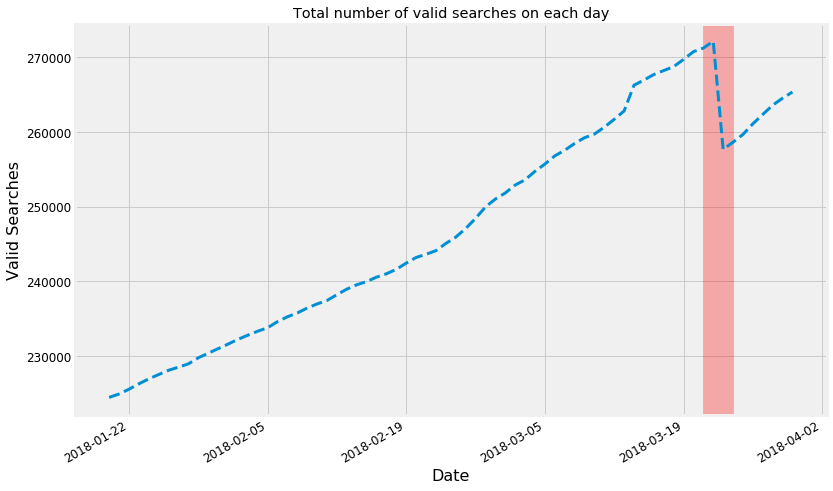

In [4]:
ax = df['num_searches'].plot(figsize=(12, 8), fontsize=12, linewidth=3, linestyle='--')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Valid Searches', fontsize=16)
ax.set_title('Total number of valid searches on each day')
ax.axvspan('2018-03-21', '2018-03-24', color='red', alpha=0.3)
plt.show()

**Observation**: The red band indicates a sharp drop in the number of valid searches on `2018-03-24`.

### Business Question: Produce, for each date, the total number of valid searches that existed on that date.
The **total number of users with valid searches per day** is captured in the `num_users` column of the dataframe. A similar trend can be observed for the num_users indicated by the red band.

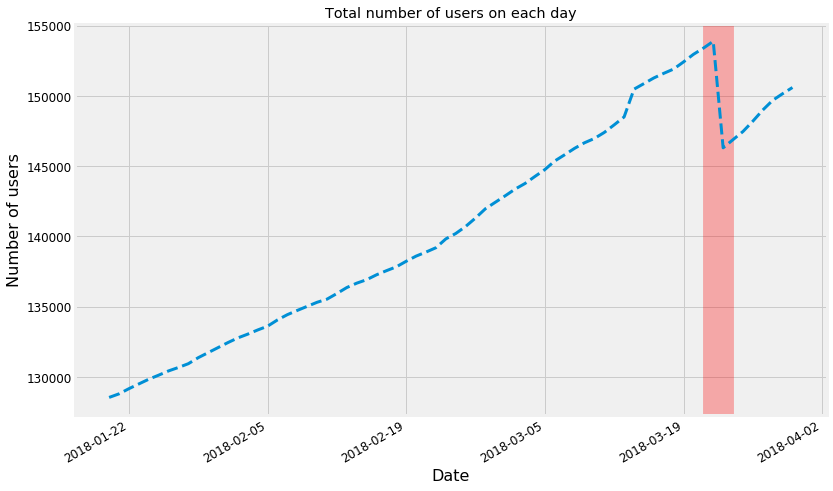

In [5]:
ax = df['num_users'].plot(figsize=(12, 8), fontsize=12, linewidth=3, linestyle='--')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Number of users', fontsize=16)
ax.set_title('Total number of users on each day')
ax.axvspan('2018-03-21', '2018-03-24', color='red', alpha=0.3)
plt.show()

### Business question: Most engaging search
From the data that is available, it appears that `Rental` searches are the most engaging ones. I am assuming that the number of valid searches is a good indicator to guage user engagement. It is evident from the below plot, that Rental Searches are consistently producing more valid searches than `Sale` type searches.

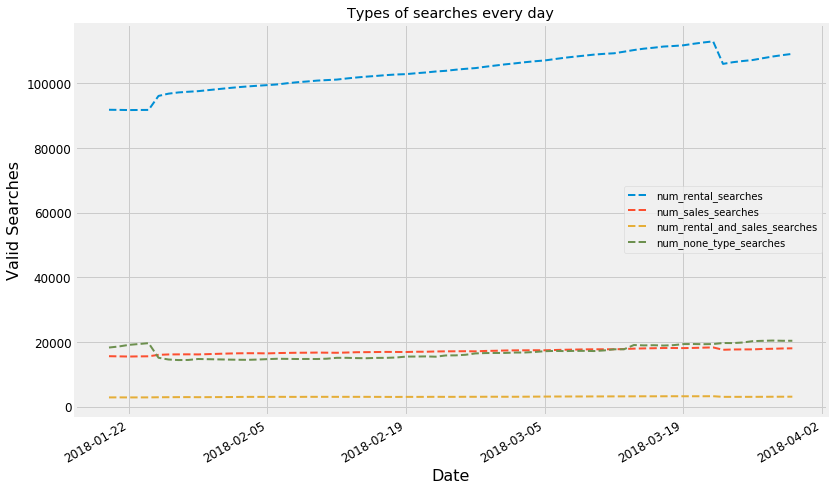

In [10]:
ax = df[['num_rental_searches', 
         'num_sales_searches', 
         'num_rental_and_sales_searches',
        'num_none_type_searches']].plot(figsize=(12, 8), fontsize=12, linewidth=2, linestyle='--')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Valid Searches', fontsize=16)
ax.set_title('Types of searches every day')
ax.legend(fontsize=10)
plt.show()

### Business question: What would the email traffic look like if we changed the definition of a valid search from 3 clicks to 2?
When the defintion of valid search is changed from `clicks >= 3` to `clicks >= 2` the number of searches and its corresponding stats increase in size. Shown below is a comparison for the first 3 days:

![clicks](streeteasy-images/clicks.png)

This means that the **email traffic would increase**.

### Business question: Report any interesting trends over the timespan of the data available.
Mainly there are two trends observed with this timeseries data:
- One is that there is a steady increase in the number of searches made and also in the number of users. The stats corresponding to individual search type shows that Rental searches are growing faster than Sales searches. 
- Second interesting thing that I found was a sharp dip in the number of searches and users on 2018-03-23, which could be something interesting to investigate.

## Recommendations

### Recommendations in data storage: 
In terms of storing data, using CSV files comes with some problems down the line. Here are some difficulties with CSV files:
- No defined schema: There are no data types included and column names beyond a header row.
- Nested data requires special handling:
-
In addition to these issues with using CSV file format, **Spark** has some **specific problems** when working with CSV data:
- CSV files are quite **slow to import** and parse.
- The files cannot be shared between workers during the import process.
- If no schema is defined, then all data must be read before a schema can be inferred.
- Spark has a feature known as **predicate pushdown** - which is an idea of ordering tasks to do the least amount of work. Example, *filtering* data prior to processing is one of the primary optimizations of predicate pushdown, this drastically reduces the amount of information that must be processed in large data sets. Unfortunately, we cannot filter the CSV data via predicate pushdown.
- Finally, Spark processes are often multi-step and may utilize an intermediate file representation. These representations allow data to be used later without regenerating the data from source.

Instead of using CSV, when possible use **parquet file format**.

**Parquet Format**: Parquet is a compressed columnar data format and is structured with data accessible in chunks that allows efficient read/write operations without processing the entire file. This structured format supports Spark's predicate pushdown functionality, thus providing significant performance improvement. Finally, parquet files automatically include schema information and handle data encoding. This is perfect for intermediary or on-disk representation of processed data. Note that parquet files are binary file format and can only be used with proper tools.

### Recommendations for downstream processing:
The search field coming through from the application appear to by `YAML` format. I found that writing regular expression to parse out the search field is prone to errors if the schema evolves. A better way to capture the search field is using JSON or AVRO, as this has some form of schema tied to it, so that downstream applications can know when the schema evolves.